### Initialization

In [1]:
import glob
import json
import re
import numpy
import pandas

In [2]:
from utils.text_extraction import *
from utils.document_processing import *
from utils.subject_extraction import *
from utils.similarity import *
from utils.context_extraction import *

In [3]:
import psycopg2
psycopg2_conn = psycopg2.connect(dbname='public_contracts', user='postgres', password='admin', host='localhost', port='5432')

### Subject context

In [4]:
from utils.context_extraction import *

### EvaluationMachine

In [5]:
class SubjectContextSelectionEvaluationMachine():
    
    _contracts = None
    _df_contracts = None
    _subj_context_extractor = None
    _func_params = None
    
    def __init__(self, contracts, subj_context_extractor=SubjectContextExtractor, func_params={}):
        self._contracts = contracts
        self._subj_context_extractor = subj_context_extractor
        self._func_params = func_params
    
    def process(self):
        for contr in self._contracts:
            contr_text = contr['text']
            contr['subj_context'] = self._subj_context_extractor(**self._func_params).get_subject_context(contr_text)
        self._df_contracts = pandas.DataFrame(self._contracts).set_index('id')
        return self._df_contracts
    
    def evaluate(self):
        return self._df_contracts['subj_context'].isna().sum()

In [6]:
class ComplexSubjectContextSelectionEvaluationMachine(SubjectContextSelectionEvaluationMachine):
    
    _path_to_data = None
    _validator = None
    
    def __init__(self, path_to_data, validator=validate_subj_contexts, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._path_to_data = path_to_data
        self._validator = validator
    
    def process(self):
        super().process()
        self._df_contracts = self._validator(self._df_contracts, self._path_to_data)
        self._df_contracts['valid']=False
        df_tmp = self._df_contracts[self._df_contracts.valid_rat>0.5].copy()
        df_tmp['valid']=True
        self._df_contracts['valid']=df_tmp['valid']
        return self._df_contracts
        
    def evaluate(self):
        return self._df_contracts['valid_rat'].mean()*100

### Documents 

In [7]:
from utils.document_processing import *

In [8]:
loader = DatabaseDocumentLoader(psycopg2_conn)
loader.load_documents()
documents = loader.prepare_documents()

Running query: select * from document where processed=True
Preparing total 1008 documents
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
Progress: 100.0%


In [9]:
vzdirs = '../../test-data/*/*/*/*'
ignore_contracts = ['2096','sportovni-areal-zs-slatina-1-etapa_25534',
                    'revitalizace-lokality-spaliste-k-u-stare-mesto-u-uherskeho-hradiste-akceptacni-cislo-12136894-cz-1-02-4-2-00-12-16399-dodatecne-prace_9496',
                    '35226', 'kompostujeme-v-obci-sebranice-dodavka-stepkovace-a-komposteru', 'zvysovani-povedomi-verejnosti-o-biodiverzite-luk-a-pastvin',
                    'nakup-noveho-uzitkoveho-elektromobilu-typu-bev-vozidlo-s-bateriovym-pohonem']

ref_loader = ReferenceDocumentLoader(vzdirs)
# ref_loader.extract_text_from_documents(0,1024)
ref_loader.load_documents_from_extracts(ignore_contracts)
ref_documents = ref_loader.prepare_documents()

Loading total 316 extracts
Preparing total 316 documents
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 59.0%
Progress: 69.0%
Progress: 79.0%
Progress: 89.0%
Progress: 99.0%


In [10]:
ignore_mask = count_occurence_vector('qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNMáčďéěíňóřšťúůýžÁČĎÉĚÍŇÓŘŠŤÚŮÝŽ0123456789')
ignore_mask[0]=0
matcher = DocumentMatcher(ref_documents, documents)
matcher.count_most_similar_documents(ignore_mask=ignore_mask)
matcher.aggregate_documents()
df_contract = matcher.filter_aggregated()

Counting most similar documents for total 316 reference documents
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 59.0%
Progress: 69.0%
Progress: 79.0%
Progress: 89.0%
Progress: 99.0%


### Measurements

In [11]:
contracts = []
for contr_name, docs in df_contract.groupby('contr_name'):
    contr_text = ''
    contr_ids = []
    for index, doc in docs.iterrows():
        doc_name = doc['doc_name']
        contr_text += '======================='+doc_name+'=======================\n'
        contr_text += doc['doc_text']
        contr_ids.append(doc['contr_id'])
    contr_id = get_most_frequent(contr_ids)
    contr = {'id': contr_id, 'contr_name': contr_name, 'text': contr_text}
    contracts.append(contr)

In [12]:
%%time 

vzdirs = '../../test-data/*/*/*'

keywords = {
    'Předmět smlouvy':10,
    'Předmět díla':10,
    'Předmět plnění':10,
    'Předmět veřejné zakázky':10,
    'Vymezení předmětu':10,
    'Vymezení plnění': 10,
    'Název veřejné zakázky': 3,
    'Veřejná zakázka':1,
    'Veřejné zakázce':1,
    'Předmět': 1
   }
evaluator = ComplexSubjectContextSelectionEvaluationMachine(vzdirs, validator=validate_subj_contexts_v2, contracts=contracts,
                                                            subj_context_extractor=AdvancedSubjectContextExtractor,
                                                            func_params={'keywords': keywords, 'subj_range': 2000})
evaluator.process()
score = evaluator.evaluate()
print('Score: ' + str(score))
# print('Improve: ' + str(score - last_score))
# last_score = score
# df_last_contracts = df_contracts
df_contracts = evaluator._df_contracts
# scores3['w/o_capitals'] = score

C:\x\diplomka\research\researchenv\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Score: 75.86453338142519
Wall time: 9.88 s


In [878]:
# save_valid_contexts(df_contracts, df_contract)

### Playground

In [13]:
print(df_contracts.reset_index())

     id                                         contr_name  \
0    71  e-zakazky/48a575ba-f8fe-47f2-bbb6-c6ddb26390ef...   
1    72  e-zakazky/73b0be6b-6b49-4ab4-a6a0-508b83a305e1...   
2    74  e-zakazky/c265fdf8-044f-44e5-b36e-df4ca53c6179...   
3    61                    eagri/mze/contract_display_6220   
4    64                             ezak/mpsv/P15V00000447   
5    66                             ezak/mpsv/P16V00000187   
6    67                             ezak/mpsv/P16V00000240   
7   103                              nipez/mo/P18V00009525   
8   207                              nipez/mo/P18V00012708   
9   397                              nipez/mo/P18V00019354   
10  488                              nipez/mo/P18V00022561   
11  542                              nipez/mo/P19V00003599   
12  714                            nipez/mpsv/P18V00010416   
13  733                            nipez/mvcr/P18V00009631   
14  755                            nipez/mvcr/P18V00015153   
15  771 

In [25]:
index = 23
ref_context = df_contracts.iloc[index]['ref_context']
subj_context = df_contracts.iloc[index]['subj_context']
print('===========================')
print(ref_context)
print('===========================')
print(subj_context)


v článku 21 této zadávací dokumentace (dále jen „ZD“).  

2. Vymezení předmětu veřejné zakázky 

2.1. Obecné vymezení předmětu veřejné zakázky 
Dle ustanovení § 26 a § 53 zákona se jedná o podlimitní veřejnou zakázku na stavební práce 

s názvem „Silnice III/26322 - Mlýny“ 

 

Klasifikace předmětu veřejné zakázky 

kód CPV: 45233141-9 - Práce na údržbě silnic  

kód CPV: 45233223-8 - Obnova povrchu vozovky 

kód CPV: 45233290-8 - Instalace a montáž dopravního značení 

kód CPV: 50230000-6 - Opravy a údržba silnic a dalších zařízení a související služby 

Předmět plnění této veřejné zakázky: 

Předmětem této veřejné zakázky je velkoplošná oprava silnice III/26322 mezi Českou 

Kamenicí a Kytlicí se začátkem na rozhraní Libereckého a Ústeckého kraje s koncem na 

začátku obce Kytlice – Mlýny. V celém úseku km 1,290 – km 3,645 budou provedeny 

údržbové práce v podobě souvislé údržby povrchu spočívající v pokládce asfaltových vrstev. 

Napojení na stávající komunikace v místech přiléhaj

In [26]:
text = df_contracts.iloc[index]['text']

In [27]:
print(text)

=======================06_D01_OLP_465_2019_dodatek_c1.pdf=======================

1

Dodatek č. 1

ke smlouvě o provedení stavby č. OLP/465/2019

"Silnice III/26322 - Mlýny"

uzavřený mezi těmito smluvními stranami:

Liberecký kraj

se sídlem U Jezu 642/2a, Liberec, 460 01

IČO: 70891508

DIČ: CZ70891508

zastoupený Martinem Půtou, hejtmanem, v plné moci Ing. Janem Svitákem, náměstkem 

hejtmana  

bankovní spojení: Komerční banka, a.s.    

číslo účtu: 19-7964000277/0100                       

dále jen „objednatel“

a 

Silnice Žáček s.r.o.             

se sídlem Antonína Sovy 965, 470 01 Česká Lípa  

IČO: 445 69 432

DIČ: CZ44569432    

osoba oprávněná podepsat dodatek: Ing. Pavel Žáček, jednatel společnosti    

bankovní spojení: ČSOB Česká Lípa

číslo účtu: 676377983/0300

evidence: v obchodním rejstříku u Krajského soudu v Ústí nad Labem, oddíl C, vložka 2261

dále jen „zhotovitel“

takto:

 

Ministerstvo dopravy
Státní fond soon)
infrastruktury




2

Úvodní ustanovení

1. S

In [28]:
extractor = AdvancedSubjectContextExtractor(keywords=keywords)

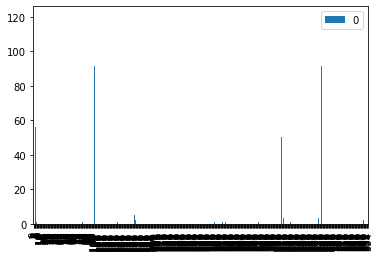

In [29]:
extractor.show_occurrence_distribution(text)

In [34]:
extractor.get_subject_context_start(text)

272726

In [35]:
extractor.get_subject_context_end(text, 272726)

275009

In [36]:
print(text[272726: 275009])

Vymezení předmětu veřejné zakázky 


2.1. Obecné vymezení předmětu veřejné zakázky 
Dle ustanovení § 26 a § 53 zákona se jedná o podlimitní veřejnou zakázku na stavební práce 


s názvem „Silnice III/26322 - Mlýny“ 


 


Klasifikace předmětu veřejné zakázky 


kód CPV: 45233141-9 - Práce na údržbě silnic  


kód CPV: 45233223-8 - Obnova povrchu vozovky 


kód CPV: 45233290-8 - Instalace a montáž dopravního značení 


kód CPV: 50230000-6 - Opravy a údržba silnic a dalších zařízení a související služby 


Předmět plnění této veřejné zakázky: 


Předmětem této veřejné zakázky je velkoplošná oprava silnice III/26322 mezi Českou 


Kamenicí a Kytlicí se začátkem na rozhraní Libereckého a Ústeckého kraje s koncem na 


začátku obce Kytlice – Mlýny. V celém úseku km 1,290 – km 3,645 budou provedeny 


údržbové práce v podobě souvislé údržby povrchu spočívající v pokládce asfaltových vrstev. 


Napojení na stávající komunikace v místech přiléhajících zpevněných ploch a křižovatek bude 



htt

In [682]:
df_contracts.at[index, 'subj_context2']

'  Článek II\n\nPředmět smlouvy\n(1)     Na základě této smlouvy se prodávající zavazuje dodat kupujícímu zboží a převést na něj vlastnické právo ke zboží, za podmínek dohodnutých v dalších ustanoveních smlouvy. Kupující se zavazuje zboží bez vad předané převzít a zaplatit za ně prodávajícímu kupní cenu, specifikovanou v čl. IV smlouvy, na základě dohodnutých platebních podmínek.\n(2)     Předmětem smlouvy je dodávka nových školících pomůcek a zařízení, v souladu s potřebami a požadavky kupujícího. Podrobná specifikace předmětu smlouvy je obsažena v Příloze č. 1 smlouvy. Prodávající se zavazuje dodat kupujícímu zboží ve smluveném množství, jakosti, provedení, termínech a ceně. Dále je prodávající povinen předat kupujícímu doklady, které se ke zboží vztahují a umožnit kupujícímu nabýt vlastnické právo ke zboží. Součástí předmětu smlouvy je též doprava předmětu smlouvy na místo plnění, jeho montáž, uvedení do provozu a zaškolení pracovníků kupujícího.\n(3) Prodávající se zavazuje umožnit

In [681]:
df_contracts.at[index, 'subj_context2'] = """  Článek II

Předmět smlouvy
(1)     Na základě této smlouvy se prodávající zavazuje dodat kupujícímu zboží a převést na něj vlastnické právo ke zboží, za podmínek dohodnutých v dalších ustanoveních smlouvy. Kupující se zavazuje zboží bez vad předané převzít a zaplatit za ně prodávajícímu kupní cenu, specifikovanou v čl. IV smlouvy, na základě dohodnutých platebních podmínek.
(2)     Předmětem smlouvy je dodávka nových školících pomůcek a zařízení, v souladu s potřebami a požadavky kupujícího. Podrobná specifikace předmětu smlouvy je obsažena v Příloze č. 1 smlouvy. Prodávající se zavazuje dodat kupujícímu zboží ve smluveném množství, jakosti, provedení, termínech a ceně. Dále je prodávající povinen předat kupujícímu doklady, které se ke zboží vztahují a umožnit kupujícímu nabýt vlastnické právo ke zboží. Součástí předmětu smlouvy je též doprava předmětu smlouvy na místo plnění, jeho montáž, uvedení do provozu a zaškolení pracovníků kupujícího.
(3) Prodávající se zavazuje umožnit osobám oprávněným k výkonu kontroly projektu, z něhož bude zakázka hrazena, provést kontrolu dokladů souvisejících s plněním zakázky a to minimálně do 31. 12. 2025.

(4) Prodávající se zavazuje uchovávat veškeré originály účetních dokladů a originály dalších dokumentů souvisejících s realizací projektu, z něhož bude zakázka hrazena, dle zákona č. 563/1991 Sb., o účetnictví, ve znění pozdějších předpisů, minimálně do 31. 12. 2025. 

(5) Prodávající se zavazuje řídit se v případě publicity na všech dokumentech souvisejících s projektem, z něhož bude zakázka hrazena, pravidly publicity projektů financovaných z programu OPVK a pravidly vizuální identity ESF v ČR dle příručky pro příjemce finanční podpory projektů OPVK.

(6) Prodávající se zavazuje dodržovat při plnění předmětu smlouvy opatření bezpečnosti, požární ochrany a ochrany zdraví při práci.

(7) Prodávající se zavazuje splnit předmět smlouvy prostřednictvím osob s potřebnou kvalifikací a odborností.

Článek III
"""

In [650]:
df_subj_context2 = df_contracts.loc[0:39]['subj_context2']
df_subj_context2

id
0     \nSmlouva nabývá platnosti a účinnosti dnem po...
1     \nTito uvedení zástupci jsou oprávněni jednat ...
2     \njménem zadavatele\n\n \n\n2. Předmět veřejné...
3     \n(dále jen „zhotovitel “ nebo „projektant“)\n...
4     \nvyhotovil tuto písemnou zprávu.\n\n1. Předmě...
5     \nprohlášení nebo v souvislosti s ní druhé sml...
6     \nmluvní straně vznikne.\nČlánek 2\nPředmět Sm...
7     \nOdůvodnění: Veřejnou zakázku malého rozsahu....
8     \nIdentifikace veřejné zakázky\n\nNázev veřejn...
9     \nvěstníku EU, na veřejnou zakázku „Programové...
10    \nJana Velíšková, tel. + 420 973 225 210.\n\n2...
11    \npovinen dodržet zásady podle $ 6 ZZVZ.\n\n2....
12    \ntéto Smlouvy a je odborně způsobilý ke splně...
13    \nrozhodl o výběru dodavatele k veřejné zakázc...
14    \nStrana 2\n\nII.\nPředmět plnění\n1. Předměte...
15    \nIdentifikace veřejné zakázky\n\n\tNázev veře...
16    \nOdůvodnění: Veřejnou zakázku malého rozsahu....
17    \nNabídku lze podat pouze elektronicky 